<a href="https://colab.research.google.com/github/iryna-savchuk/DL_project/blob/catiaparrinha/3.model_handcrafted.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**University:** NOVA Information Management School<br/>
**Program:** Master’s Degree Program in Data Science and Advanced Analytics<br/>
**Academic Year:** 2022/2023

```
============== Students: ==============
Iryna Savchuk (m20211310@novaims.unl.pt)
Cátia Sofia Pereira Parrinha (m20201320@novaims.unl.pt)
Giulia Bovenga (m20221637@novaims.unl.pt)
Hubert Oberhauser (m20220628@novaims.unl.pt)
Leo Allgaier (m20220635@novaims.unl.pt)
=======================================
```

# Import packages

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential, layers, initializers, regularizers, optimizers, metrics 

import os
import time
import shutil
import random 
import zipfile

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap

# Import Clean Dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [17]:
# Set the machine
gdrive = True
# Set the connection string
path = "/content/gdrive/MyDrive/DL_Project/"
main_folder, training_folder, validation_folder, testing_folder = "datasets/", "train/", "validation/", "test/"
# If using Google Drive
if gdrive:
    # Setup drive
    from google.colab import drive
    drive.mount('/content/gdrive')        
    # Transfer zip dataset to the current virtual machine
    t0 = time.time()
    shutil.copyfile(path + 'datasets.zip', 'datasets.zip')
    # Extract files
    zip_ = zipfile.ZipFile('datasets.zip')
    zip_.extractall()
    zip_.close()
    print("File transfer completed in %0.3f seconds" % (time.time() - t0))
    path = "/content/"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
File transfer completed in 1.240 seconds


# List of parameters

In [18]:
image_size=(128, 128)  
crop_to_aspect_ratio=False 
color_mode='rgb'  
batch_size=64  
label_mode="categorical"  
shuffle=True  
seed=0  

# Create Train, validation and test datasets

In [19]:
# Generate an object of type tf.data.Dataset 
ds_train = image_dataset_from_directory(path + main_folder + training_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_validation = image_dataset_from_directory(path + main_folder + validation_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

ds_test = image_dataset_from_directory(path + main_folder + testing_folder, 
                                                image_size=image_size,
                                                crop_to_aspect_ratio=crop_to_aspect_ratio,
                                                color_mode=color_mode,
                                                batch_size=batch_size,
                                                label_mode=label_mode,
                                                shuffle=shuffle,
                                                seed=seed)

# Check object properties
print("\nObject's type:\t", type(ds_train))
print("Is it a tf.data.Dataset?\t R:",isinstance(ds_train, tf.data.Dataset))
print("Classes:", ds_train.class_names)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Found 128 files belonging to 3 classes.

Object's type:	 <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Is it a tf.data.Dataset?	 R: True
Classes: ['angular_leaf_spot', 'bean_rust', 'healthy']


In [20]:
iter_train = iter(ds_train)
batch_x_train, batch_y_train = iter_train.next()
print(batch_x_train.shape, batch_y_train.shape)
print("\nSample of x_train:", batch_x_train[0, 0:2, 0:2, 0])  # [Batch Size, H, W; C], first image, the first two pixels , of the very first channel
print("\nSample of y_train:", batch_y_train[0:5])  # the first 5 values form the vector
print("Sample average of y_train:", tf.reduce_mean(batch_y_train))  # reflects the balance of our target

(64, 128, 128, 3) (64, 3)

Sample of x_train: tf.Tensor(
[[ 99.26709   99.308105]
 [107.84375  138.55054 ]], shape=(2, 2), dtype=float32)

Sample of y_train: tf.Tensor(
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 1. 0.]], shape=(5, 3), dtype=float32)
Sample average of y_train: tf.Tensor(0.33333334, shape=(), dtype=float32)


# Augmentation

In [21]:
augmentation = Sequential([layers.RandomFlip(), 
                           layers.RandomRotation(factor=0.2), 
                           layers.RandomZoom(height_factor=0.1, width_factor=0.1),
                           layers.RandomContrast(factor=0.3),
                           layers.RandomBrightness(factor=0.3),
                           layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1))], 
                           name="my_augmentation_pipeline")
# maybe we can explore different factors

In [22]:
def show_augmented_sample_batch(batch_x, augmentation_pipe, trials=4, fig_size=(10, 6)):
    # Plot the images
    _, axs = plt.subplots(len(batch_x), trials + 1, figsize=(10, 6), layout='constrained')
    for i, img in enumerate(batch_x):
        axs[i, 0].imshow(tf.cast(img, tf.int32))
        axs[i, 0].set_title("Original image", size=8)
        for t in range(trials):
            # Pass through the augmentation pipeline
            augmented_i = augmentation_pipe(img, training=True)
            axs[i, t+1].imshow(tf.cast(augmented_i, tf.int32))
            axs[i, t+1].set_title("Transformed image#{}".format(t), size=8)

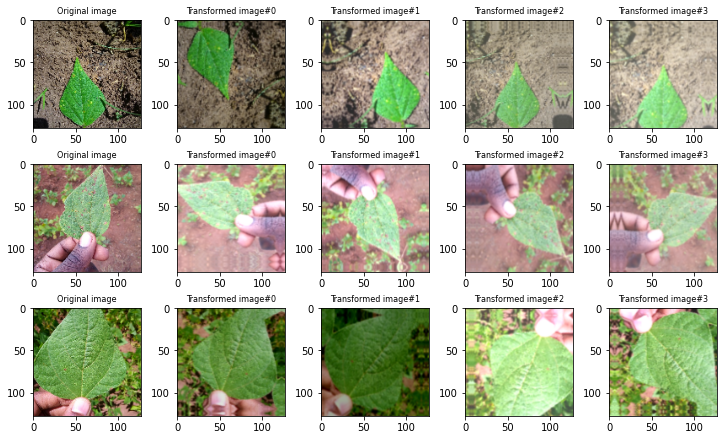

In [23]:
show_augmented_sample_batch(batch_x_train[0:3], augmentation_pipe=augmentation)

# Architectures

In [25]:
input_shape = tuple(batch_x_train.shape)
input_shape

(64, 128, 128, 3)

In [26]:
input_shape[1:]

(128, 128, 3)

## CNN 1

In [27]:
# Architecture V1
cnn1 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), 
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V1")
# Builds the DAG (comment if input_shape was already provided to the first layer or via layers.Input)
cnn1.build(input_shape)
# Check network
cnn1.summary()  

Model: "CNN-V1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 18)      1368      
                                                                 
 activation (Activation)     (None, 124, 124, 18)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 18)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 48)        21648     
                                                                 
 activation_1 (Activation)   (None, 58, 58, 48)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 48)       0         
 2D)                                                        

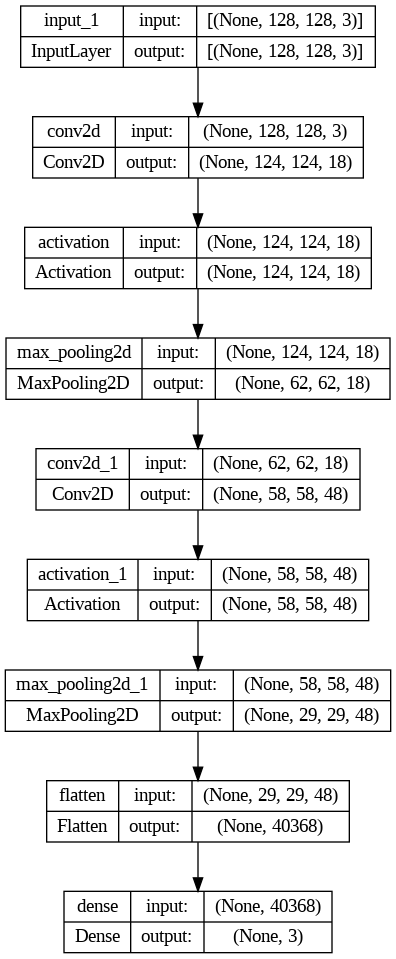

In [29]:
# alternatively use 
tf.keras.utils.plot_model(cnn1, show_shapes=True)

In [30]:
# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn1.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V1)
epochs = 5
history1 = cnn1.fit(ds_train, epochs=epochs, validation_data=ds_validation)

Epoch 1/5
17/17 [==============================] - 18s 383ms/step - loss: 1.2723 - categorical_accuracy: 0.3211 - AUROC: 0.4903 - val_loss: 1.6096 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4709
Epoch 2/5
17/17 [==============================] - 3s 98ms/step - loss: 1.1990 - categorical_accuracy: 0.3453 - AUROC: 0.5043 - val_loss: 1.2240 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4964
Epoch 3/5
17/17 [==============================] - 3s 93ms/step - loss: 1.1694 - categorical_accuracy: 0.3598 - AUROC: 0.5254 - val_loss: 1.3432 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5007
Epoch 4/5
17/17 [==============================] - 3s 120ms/step - loss: 1.1645 - categorical_accuracy: 0.3520 - AUROC: 0.5088 - val_loss: 1.2892 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4988
Epoch 5/5
17/17 [==============================] - 3s 97ms/step - loss: 1.2149 - categorical_accuracy: 0.3414 - AUROC: 0.4997 - val_loss: 1.9762 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.49

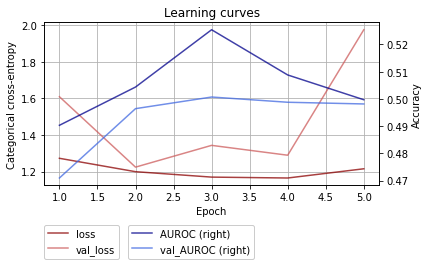

In [31]:
# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history1.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #  ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN2 

Epoch 1/5
17/17 [==============================] - 4s 109ms/step - loss: 1.3199 - categorical_accuracy: 0.3279 - AUROC: 0.5144 - val_loss: 1.4449 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4962
Epoch 2/5
17/17 [==============================] - 3s 98ms/step - loss: 1.1827 - categorical_accuracy: 0.3259 - AUROC: 0.4968 - val_loss: 1.2301 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5000
Epoch 3/5
17/17 [==============================] - 4s 159ms/step - loss: 1.1792 - categorical_accuracy: 0.3298 - AUROC: 0.5093 - val_loss: 1.6394 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5000
Epoch 4/5
17/17 [==============================] - 3s 98ms/step - loss: 1.2153 - categorical_accuracy: 0.3279 - AUROC: 0.4967 - val_loss: 1.2034 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5038
Epoch 5/5
17/17 [==============================] - 3s 96ms/step - loss: 1.2003 - categorical_accuracy: 0.3346 - AUROC: 0.4938 - val_loss: 1.9229 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.500

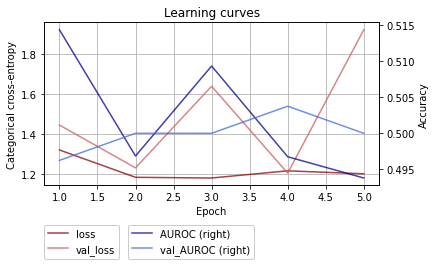

In [32]:
# Architecture V2
cnn2 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), # subsampling
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V2")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn2.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V2)
epochs = 5
history2 = cnn2.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history2.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"]  #["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN3

Epoch 1/5


17/17 [==============================] - ETA: 0s - loss: 1.3110 - categorical_accuracy: 0.3327 - AUROC: 0.5000

17/17 [==============================] - 31s 1s/step - loss: 1.3110 - categorical_accuracy: 0.3327 - AUROC: 0.5000 - val_loss: 1.2962 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4962
Epoch 2/5
17/17 [==============================] - 26s 1s/step - loss: 1.1543 - categorical_accuracy: 0.3685 - AUROC: 0.5263 - val_loss: 1.5308 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5000
Epoch 3/5
17/17 [==============================] - 26s 2s/step - loss: 1.1935 - categorical_accuracy: 0.3337 - AUROC: 0.5102 - val_loss: 1.6181 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5038
Epoch 4/5
17/17 [==============================] - 25s 1s/step - loss: 1.1902 - categorical_accuracy: 0.3501 - AUROC: 0.5157 - val_loss: 1.4627 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5038
Epoch 5/5
17/17 [==============================] - 23s 1s/step - loss: 1.1539 - categorical_accuracy: 0.3656 - AUROC: 0.5287 - val_loss: 1.3087 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.4962


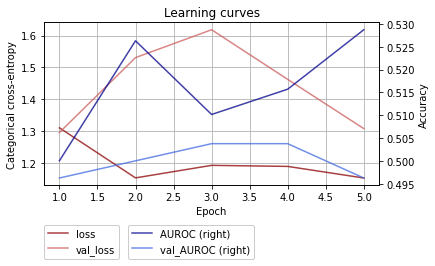

In [33]:
# Architecture V3
cnn3 = Sequential([# Input layer
                   layers.Input(input_shape[1:]),
                    # Data augmentation
                   augmentation, 
                   # Data preprocessing
                   layers.Rescaling(1./255),
                   # Feature extraction
                   layers.Conv2D(filters=6*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)), # subsampling
                   # repeat
                   layers.Conv2D(filters=16*input_shape[-1], 
                                 kernel_size=(5, 5),
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("softmax"),
                   layers.MaxPooling2D(pool_size=(2, 2)),
                   # From a HxWxC cuboid to a (H*W*C) vector per image
                   layers.Flatten(), 
                   # Classification (use units=n_classes, activation="softmax" for multi-class)
                   layers.Dense(units=3, # one layer
                                activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V3")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn3.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training (V3)
epochs = 5
history3 = cnn3.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history3.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN4

Epoch 1/10
17/17 [==============================] - 7s 116ms/step - loss: 17.8869 - categorical_accuracy: 0.4062 - AUROC: 0.5664 - val_loss: 1.0854 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.6130
Epoch 2/10
17/17 [==============================] - 3s 93ms/step - loss: 1.0242 - categorical_accuracy: 0.5358 - AUROC: 0.6925 - val_loss: 1.0776 - val_categorical_accuracy: 0.3609 - val_AUROC: 0.5851
Epoch 3/10
17/17 [==============================] - 4s 152ms/step - loss: 0.9533 - categorical_accuracy: 0.5919 - AUROC: 0.7462 - val_loss: 1.0812 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5871
Epoch 4/10
17/17 [==============================] - 3s 95ms/step - loss: 0.9903 - categorical_accuracy: 0.5716 - AUROC: 0.7321 - val_loss: 1.0511 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.6134
Epoch 5/10
17/17 [==============================] - 3s 96ms/step - loss: 0.9347 - categorical_accuracy: 0.6335 - AUROC: 0.7644 - val_loss: 1.0711 - val_categorical_accuracy: 0.3383 - val_AUROC:

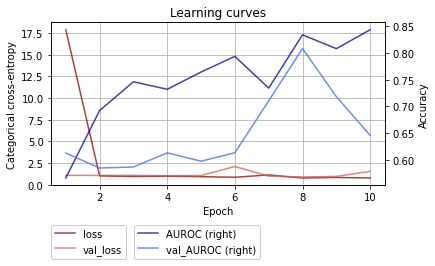

In [34]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V4
cnn4 = Sequential([# The input layer
                   layers.Input(input_shape),    
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P3
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=384, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V4")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn4.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 10
history4 = cnn4.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history4.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN5

Epoch 1/10
17/17 [==============================] - 6s 147ms/step - loss: 6.2496 - categorical_accuracy: 0.4420 - AUROC: 0.5832 - val_loss: 1.1354 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5514
Epoch 2/10
17/17 [==============================] - 2s 90ms/step - loss: 0.9174 - categorical_accuracy: 0.5861 - AUROC: 0.7571 - val_loss: 2.1382 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.5306
Epoch 3/10
17/17 [==============================] - 3s 89ms/step - loss: 0.9910 - categorical_accuracy: 0.5735 - AUROC: 0.7383 - val_loss: 1.2096 - val_categorical_accuracy: 0.3308 - val_AUROC: 0.6019
Epoch 4/10
17/17 [==============================] - 2s 90ms/step - loss: 0.9271 - categorical_accuracy: 0.5812 - AUROC: 0.7602 - val_loss: 1.0308 - val_categorical_accuracy: 0.3835 - val_AUROC: 0.6613
Epoch 5/10
17/17 [==============================] - 3s 97ms/step - loss: 0.8076 - categorical_accuracy: 0.6431 - AUROC: 0.8201 - val_loss: 1.2250 - val_categorical_accuracy: 0.3383 - val_AUROC: 0

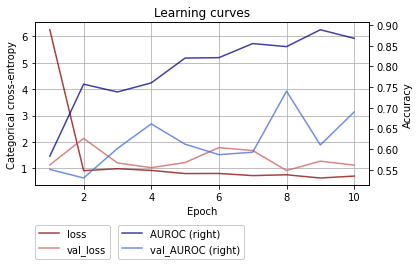

In [35]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V5
cnn5 = Sequential([# The input layer
                   layers.Input(input_shape),    
                   # Feature extraction
                   layers.Rescaling(1./255),
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V5")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn5.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 10
history5 = cnn5.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history5.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"] 
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()

## CNN6

Epoch 1/15
17/17 [==============================] - 5s 99ms/step - loss: 7.1941 - categorical_accuracy: 0.4487 - AUROC: 0.6045 - val_loss: 4.3295 - val_categorical_accuracy: 0.4586 - val_AUROC: 0.5783
Epoch 2/15
17/17 [==============================] - 3s 111ms/step - loss: 0.9420 - categorical_accuracy: 0.5754 - AUROC: 0.7454 - val_loss: 7.5508 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5042
Epoch 3/15
17/17 [==============================] - 3s 94ms/step - loss: 1.0980 - categorical_accuracy: 0.5571 - AUROC: 0.6986 - val_loss: 3.6553 - val_categorical_accuracy: 0.3383 - val_AUROC: 0.5793
Epoch 4/15
17/17 [==============================] - 3s 93ms/step - loss: 0.8709 - categorical_accuracy: 0.6170 - AUROC: 0.7913 - val_loss: 3.0287 - val_categorical_accuracy: 0.4962 - val_AUROC: 0.6270
Epoch 5/15
17/17 [==============================] - 3s 93ms/step - loss: 0.8948 - categorical_accuracy: 0.6141 - AUROC: 0.7887 - val_loss: 0.8888 - val_categorical_accuracy: 0.5639 - val_AUROC: 0

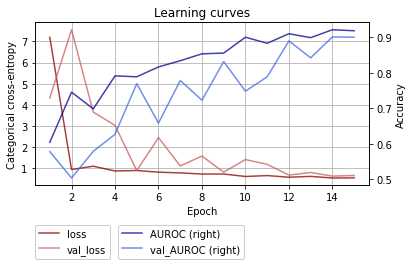

In [36]:
# Defines input shape from image size
input_shape = (*image_size, 3)
dropout_rate = 0.2
# Architecture V5
cnn6 = Sequential([# The input layer
                   layers.Input(input_shape),    
                   # Data preprocessing
                   layers.BatchNormalization(),  
                   ## P1
                   layers.Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4), 
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.BatchNormalization(),  
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   ## P2
                   layers.Conv2D(filters=256, kernel_size=(5, 5), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same",
                                 kernel_initializer=initializers.GlorotNormal(seed=seed)),
                   layers.Activation("relu"),
                   layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
                   # From a HxWxC cuboid to a (C) vector per image
                   layers.GlobalAveragePooling2D(),
                   # Classification 
                   layers.Dropout(dropout_rate),     
                   layers.Dense(units=3, activation="softmax",
                                kernel_initializer=initializers.GlorotNormal(seed=seed))],
                   name="CNN-V6")

# Compiles the model for training.
learning_rate = 0.001  # 0.001 <=> 1e-3
cnn6.compile(loss="categorical_crossentropy",
             optimizer=optimizers.RMSprop(learning_rate=learning_rate),  
             metrics=[metrics.CategoricalAccuracy(name='categorical_accuracy'),
                      metrics.AUC(name='AUROC')])

# Model training 
epochs = 15
history6 = cnn6.fit(ds_train, epochs=epochs, validation_data=ds_validation)

# Create DataFrame object
df_hist = pd.DataFrame.from_dict(history6.history)
df_hist["Epoch"] = np.arange(1, len(df_hist) + 1, 1)
# Plot learning curves
secondary_y = ["AUROC", "val_AUROC"] # ["accuracy", "val_accuracy"]
ax = df_hist.plot(x="Epoch", y=['loss', 'val_loss'] + secondary_y,
                  secondary_y = secondary_y,
                  kind="line", figsize=(6, 3), grid=True, legend=True,
                  ylabel="Categorical cross-entropy", 
                  xlabel="Epoch", title="Learning curves",                  
                  color=['darkred', 'indianred', "darkblue", "royalblue"], alpha=0.75, fontsize=10)
ax.right_ax.set_ylabel("Accuracy")
ax.right_ax.legend(loc=(0.25, -0.45), framealpha=1.0)
ax.legend(loc=(0, -0.45), framealpha=1.0)
plt.show()